In [3]:
all_runs = []
good_runs = []

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
0.002532555954530835


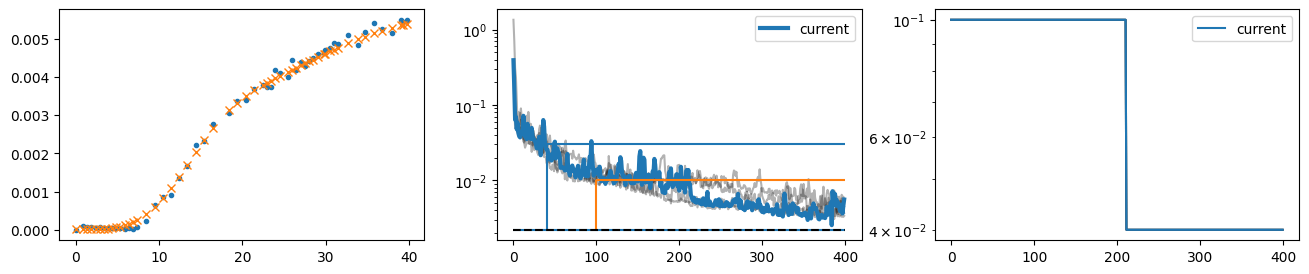

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler


class ScaledTrainingModel(keras.Model):
    def __init__(
        self, model: keras.Model, x_scaler: MinMaxScaler, y_scaler: StandardScaler
    ):
        super().__init__()
        self.model = model
        self.x_scaler = x_scaler
        self.y_scaler = y_scaler

    def fit(self, x, y, *args, **kwargs):
        x = self.x_scaler.transform(x)
        y = self.y_scaler.transform(y)
        return super().fit(x, y, *args, **kwargs)

    def call(self, x, *args, **kwargs):
        return self.model.call(x, *args, **kwargs)

    def predict(self, x):
        x_scaled = self.x_scaler.transform(x)
        y_scaled = self.model.predict(x_scaled)
        return self.y_scaler.inverse_transform(y_scaled)


x_train = np.load("../data_out/p3inn/core2/x_data.npy")
y_train = np.load("../data_out/p3inn/core2/y_data.npy")

model = ScaledTrainingModel(
    keras.models.Sequential(
        [
            keras.Input((1,)),
            keras.layers.Dense(32, "tanh"),
            keras.layers.Dense(1),
        ]
    ),
    x_scaler=MinMaxScaler().fit(x_train),
    y_scaler=StandardScaler().fit(y_train),
)

# lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
#     # [30, 60, 180], [0.2, 0.15, 0.05, 0.01]
# )
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    # [1000], [0.04, 0.01]  # baseline
    # [400, 1000], [0.08, 0.04, 0.01]  # converged (loss=0.00236) at 400 but a bit unstable for 200-400
    # [300, 400, 1000], [0.1, 0.08, 0.04, 0.01]  # converged (0.00250) at 400 but unstable for 210-400 but much faster than above for 100-200
    [210, 400, 1000], [0.1, 0.04, 0.01, 0.01]  # converged (0.00219) at 400 and very clean
    # [40, 100, 300], [0.01 * 30, 0.01 * 15, 0.01 * 5, 0.01 * 1]
    # [5, 10, 40], [0.01 * 10, 0.01 * 20, 0.01 * 10, 0.01 * 1]
)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda s: float(lr_schedule(s)))
MAX_EPOCHS = 400
lrs = np.array([lr_schedule(s) for s in range(MAX_EPOCHS)])
model.compile(loss="mse", optimizer=keras.optimizers.Adam())

history = model.fit(
    x_train, y_train, shuffle=True, epochs=MAX_EPOCHS, batch_size=8, verbose=0, callbacks=[lr_scheduler]
)

y_train_pred = model.predict(x_train)
print(np.min(history.history["loss"]))


EPOCHS_AND_THRESHOLDS = [
    (40, 0.03),
    (100, 1e-2),
    (400, 0.0022),
]


fig, axs = plt.subplots(ncols=3, figsize=(16, 3))
axs[0].plot(x_train, y_train, ".")
axs[0].plot(x_train, y_train_pred, "x")
for old_lrs, old_loss in all_runs:
    if (np.array(old_loss) > 1000).any():
        continue
    axs[1].semilogy(old_loss, "k-", alpha=0.3)
    axs[2].semilogy(lrs, "k-", alpha=0.3)
axs[1].semilogy(history.history["loss"], lw=3, label="current")
axs[1].hlines(0.0022, 0, MAX_EPOCHS)
axs[2].semilogy(lrs, label="current")

for i, (n, a) in enumerate(EPOCHS_AND_THRESHOLDS):
    axs[1].vlines(n, 0.0022, a, color=f"C{i}")
    axs[1].hlines(a, n, len(history.history["loss"]), color=f"C{i}")
axs[1].plot([0, len(history.history["loss"])], [EPOCHS_AND_THRESHOLDS[-1][1]]*2, "k--")


# axs[2].semilogy(history.history["loss"], lw=3, label="baseline")
# axs[3].semilogy(lrs, label="baseline")

axs[1].legend()
axs[2].legend()
plt.show()

all_runs.append((lrs, np.array(history.history["loss"])))

# Save Run

In [5]:

# fig, axs = plt.subplots(ncols=4, figsize=(16, 3))
# axs[0].plot(x_train, y_train, ".")
# axs[1].plot(x_train, y_train, ".")
# axs[1].plot(x_train, y_train_pred, "x")
# for old_lrs, old_loss in all_runs:
#     if (np.array(old_loss) > 1000).any():
#         continue
#     axs[2].semilogy(old_loss, "k-", alpha=0.3)
#     axs[3].semilogy(lrs, "k-", alpha=0.3)
# axs[2].semilogy(history.history["loss"], lw=3, label="current")
# axs[2].hlines(0.03, 0, 600, color="k")
# axs[3].semilogy(lrs, label="current")

# # axs[2].semilogy(history.history["loss"], lw=3, label="baseline")
# # axs[3].semilogy(lrs, label="baseline")
# axs[2].set_xlim(0, 100)
# axs[2].legend()
# axs[3].legend()
# plt.show()

In [6]:
# baseline = (lrs, np.array(history.history["loss"]))
# good_runs.append((lrs, np.array(history.history["loss"])))

In [7]:
# lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
#     # [1000], [0.04, 0.01]  # baseline
#     # [400, 1000], [0.08, 0.04, 0.01]  # converged (loss=0.00236) at 400 but a bit unstable for 200-400
#     # [300, 400, 1000], [0.1, 0.08, 0.04, 0.01]  # converged (0.00250) at 400 but unstable for 210-400 but much faster than above for 100-200
#     [210, 400, 1000], [0.1, 0.04, 0.01, 0.01]  # converged (0.00219) at 400 and very clean
#     # [40, 100, 300], [0.01 * 30, 0.01 * 15, 0.01 * 5, 0.01 * 1]
#     # [5, 10, 40], [0.01 * 10, 0.01 * 20, 0.01 * 10, 0.01 * 1]
# )